# Importing Libraries

In [ ]:
pip install --user -U nltk

In [ ]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import os
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import random

# Data Extraction / Exploration

In [3]:
def parse_reuters_sgm(file_path):

    with open(file_path, 'r', encoding='latin-1') as file:
        data = file.read()
    
    soup = BeautifulSoup(data, 'html.parser')
    articles = []

    for reuters in soup.find_all('reuters'):

        # Extract TITLE
        title = reuters.find('title').text if reuters.find('title') else None

        # Extract LEWISSPLIT attribute
        lewissplit = reuters.get('lewissplit', 'UNKNOWN')

        # Extract PLACES
        places = [d.text for d in reuters.find('places').find_all('d')] if reuters.find('places') else []

        # Extract DATE
        date = reuters.find('date').text if reuters.find('date') else None

        # Extract DATELINE
        dateline = reuters.find('dateline').text if reuters.find('dateline') else None

        # Extract BODY
        body = reuters.find('text').body.text if reuters.find('text') and reuters.find('text').body else None

        # Extract TOPICS
        topics = [d.text for d in reuters.find('topics').find_all('d')] if reuters.find('topics') else []

        # Append all extracted features to articles list
        articles.append({
            'TITLE': title,
            'LEWISSPLIT': lewissplit,
            'PLACES': places,
            'DATE': date,
            'DATELINE': dateline,
            'BODY': body,
            'TOPICS': topics
        })
    
    return articles

def process_all_sgm_files(directory_path):
    """
    Process all .sgm files in a directory and combine the data into a single DataFrame.
    """
    all_articles = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.sgm'):
            file_path = os.path.join(directory_path, file_name)
            articles = parse_reuters_sgm(file_path)
            all_articles.extend(articles)
    
    return pd.DataFrame(all_articles)


In [13]:
# Directory containing the .sgm files
directory = 'reuters21578'

# Process all .sgm files and create a DataFrame
df = process_all_sgm_files(directory)

In [14]:
df.sample(7)

,TITLE,LEWISSPLIT,PLACES,DATE,DATELINE,BODY,TOPICS
10105,LANDMARK SAVINGS <LSA> TO REPURCHASE SHARES,TRAIN,[usa],2-APR-1987 09:27:12.03,"PITTSBURGH, April 2 -",Landmark Savings Association said its\nboard h...,[]
13346,PHILIPPINE CENTRAL BANKER FACES CORRUPTION CHA...,TRAIN,[philippines],24-MAR-1987 10:42:01.79,"MANILA, March 24 -",A government-appointed special\nprosecutor has...,[]
18516,CUBAN SUGAR OUTPUT SEEN AT 7.5 MLN TONNES,TRAIN,"[cuba, uk]",18-MAR-1987 19:17:03.41,"LONDON, March 19 -",Cuban sugar output this season (1986/87)\nis p...,[sugar]
752,FIRST REPUBLICBANK <FRB.N> CORP 3RD QTR LOSS,TEST,[usa],20-OCT-1987 16:54:53.27,"DALLAS, Oct 20 -\n","shr diluted loss 46 cts\n net loss 6,300,00...",[earn]
3935,NUMAC OIL <NMC> HAS 59.7 MLN DLR FINANCING,TRAIN,[canada],17-MAR-1987 10:01:00.99,"Edmonton, Alberta, March 17 -",Numac Oil and Gas Ltd said it\narranged a 59.7...,[]
1651,GV MEDICAL INC <GVMI> 4TH QTR LOSS,TRAIN,[usa],25-MAR-1987 18:11:17.83,"MINNEAPOLIS, Minn., March 25 -\n",Shr loss 20 cts vs loss 26 cts\n Net loss 7...,[earn]
7530,MICROPOLIS <MLIS> TO OFFER CONVERTIBLE DEBT,TRAIN,[usa],4-MAR-1987 11:11:17.29,"NEW YORK, March 4 -",Micropolis Corp said it filed with the\nSecuri...,[]


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21578 entries, 0 to 21577
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TITLE       20841 non-null  object
 1   LEWISSPLIT  21578 non-null  object
 2   PLACES      21578 non-null  object
 3   DATE        21578 non-null  object
 4   DATELINE    19043 non-null  object
 5   BODY        19043 non-null  object
 6   TOPICS      21578 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


# Data Cleaning

In [15]:
# Supprimer les articles sans body
df = df.dropna(subset=['BODY'])

# Supprimer les articles avec des topics = '[]'
df = df[df['TOPICS'].apply(lambda x: x != [])]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10377 entries, 0 to 21577
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TITLE       10377 non-null  object
 1   LEWISSPLIT  10377 non-null  object
 2   PLACES      10377 non-null  object
 3   DATE        10377 non-null  object
 4   DATELINE    10377 non-null  object
 5   BODY        10377 non-null  object
 6   TOPICS      10377 non-null  object
dtypes: object(7)
memory usage: 648.6+ KB


In [16]:
target_topics = {'money-fx', 'ship', 'interest', 'acq', 'earn'}

# Supprimer les articles qui ne contiennent pas les topics cibles
df_cleaned = df[df['TOPICS'].apply(lambda x: bool(set(x) & target_topics))]

In [ ]:
# Si un article contient plusieurs topics, on garde uniquement le topic présent dans target_topics
df_cleaned['TOPICS'] = df_cleaned['TOPICS'].apply(lambda x: list(set(x) & target_topics)[0])

Étant donné que certains articles appartiennent à plusieurs topics présents dans `taget_topics`, une alternative consiste à effectuer une **classification multi-label** :

- Convertir les topics en une représentation binaire (un vecteur pour chaque article indiquant la présence ou l'absence de chaque topic).
- Prédire plusieurs topics pour chaque article ( exp: OneVsRestClassifier).
- Évaluer la performance du modèle à l'aide de métriques adaptées, telles que : Hamming Loss (Fraction de labels incorrectement prédits), F1-score.

In [22]:
df_cleaned.sample(4)

,TITLE,LEWISSPLIT,PLACES,DATE,DATELINE,BODY,TOPICS
1893,SALANT CORP <SLT> 1ST QTR FEB 28 NET,TRAIN,[usa],26-MAR-1987 10:21:38.88,"NEW YORK, March 26 -\n",Oper shr profit seven cts vs loss 12 cts\n ...,earn
5904,SOUTHERN NEW ENGLAND TELECOM <SNG> DECLARES DIV,TRAIN,[usa],11-MAR-1987 15:29:11.51,"NEW HAVEN, Conn., March 11 -\n",Qtly div 72 cts vs 72 cts prior\n Pay April...,earn
3817,JAPAN FOREIGN SHIPBUILDING ORDERS RISE IN FEBR...,TRAIN,[japan],17-MAR-1987 04:54:23.42,"TOKYO, March 17 -",New foreign shipbuilding orders received\nby J...,ship
17712,FORTUNE SAVINGS TO BUY FINANCIAL <FSSL> BRANCH,TRAIN,[usa],17-MAR-1987 13:32:00.56,"SUNRISE, Fla., March 17 -",<Fortune Savings Bank> said it\nagreed to buy ...,acq


In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7175 entries, 8 to 21573
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TITLE       7175 non-null   object
 1   LEWISSPLIT  7175 non-null   object
 2   PLACES      7175 non-null   object
 3   DATE        7175 non-null   object
 4   DATELINE    7175 non-null   object
 5   BODY        7175 non-null   object
 6   TOPICS      7175 non-null   object
dtypes: object(7)
memory usage: 448.4+ KB


# Descriptive Analysis
###  Descriptive Analysis with : TF-IDF, Words Frequency, Avg Body Length...

In [ ]:
# Initialiser le lemmatiseur
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """
    Retourne la catégorie grammaticale (POS) pour un mot.
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    """
    Lemmatisation d'un texte en supprimant les stopwords.
    """
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word.isalnum()]

def get_word_frequencies(texts, stop_words):
    """
    Calcule les mots les plus fréquents à partir d'une liste de textes après lemmatisation.
    """
    all_words = []
    for text in texts:
        if isinstance(text, str):
            lemmatized_words = lemmatize_text(text)
            words = [word for word in lemmatized_words if word not in stop_words]
            all_words.extend(words)
    return Counter(all_words).most_common(10)

def compute_tfidf(texts, stop_words, top_n=10):
    """
    Calcule les mots les plus significatifs selon TF-IDF après lemmatisation.
    """
    if len(texts) == 0:
        return []
    
    # Appliquer la lemmatisation et supprimer les stopwords
    processed_texts = [
        ' '.join([word for word in lemmatize_text(text) if word not in stop_words])
        for text in texts if isinstance(text, str)
    ]
    
    # Initialiser le TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Calculer la moyenne des scores TF-IDF pour chaque mot
    tfidf_avg_scores = tfidf_matrix.mean(axis=0).A1
    tfidf_scores = list(zip(feature_names, tfidf_avg_scores))
    
    # Trier les mots par score TF-IDF
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    
    return [word for word, _ in tfidf_scores[:top_n]]

def descriptive_analysis(df):
    """
    Analyse descriptive pour identifier les caractéristiques principales de chaque sujet.
    """
    stop_words = set(stopwords.words('english'))  # Stopwords à exclure
    topic_analysis = {}

    for topic in df['TOPICS'].unique():
        topic_data = df[df['TOPICS'] == topic]
        
        # Longueur moyenne du texte
        avg_body_length = topic_data['BODY'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0).mean()
        
        # Fréquence des mots dans BODY
        body_frequencies = get_word_frequencies(topic_data['BODY'], stop_words)
        
        # Fréquence des mots dans TITLE
        title_frequencies = get_word_frequencies(topic_data['TITLE'], stop_words)
        
        # TF-IDF pour BODY
        body_tfidf = compute_tfidf(topic_data['BODY'].dropna().tolist(), stop_words)
        
        # TF-IDF pour TITLE
        title_tfidf = compute_tfidf(topic_data['TITLE'].dropna().tolist(), stop_words)
        
        # Lieux les plus fréquents
        places = [place for sublist in topic_data['PLACES'] for place in sublist]
        places_frequencies = Counter(places).most_common(5)

        # Stocker les résultats
        topic_analysis[topic] = {
            'Average BODY Length': avg_body_length,
            'Top Words in BODY': body_frequencies,
            'TF-IDF Words in BODY': body_tfidf,
            'Top Words in TITLE': title_frequencies,
            'TF-IDF Words in TITLE': title_tfidf,
            'Top Places': places_frequencies
        }
    
    return topic_analysis

In [25]:
# Perform descriptive analysis
analysis_results = descriptive_analysis(df_cleaned)

# Display results
for topic, details in analysis_results.items():
    print(f"\nTopic: {topic}")
    for key, value in details.items():
        print(f"  {key}: {value}")


Topic: money-fx
  Average BODY Length: 214.48755490483163
  Top Words in BODY: [('say', 3094), ('bank', 1666), ('dollar', 1308), ('rate', 1283), ('market', 1074), ('pct', 899), ('currency', 803), ('reuter', 678), ('exchange', 652), ('would', 636)]
  TF-IDF Words in BODY: ['say', 'bank', 'stg', 'mln', 'dollar', 'rate', 'pct', 'market', 'billion', 'yen']
  Top Words in TITLE: [('market', 163), ('money', 144), ('say', 108), ('bank', 100), ('dollar', 95), ('mln', 76), ('stg', 75), ('japan', 74), ('fed', 70), ('currency', 64)]
  TF-IDF Words in TITLE: ['market', 'money', 'bank', 'say', 'dollar', 'mln', 'stg', 'fed', 'japan', 'currency']
  Top Places: [('usa', 231), ('uk', 171), ('japan', 164), ('west-germany', 104), ('france', 40)]

Topic: interest
  Average BODY Length: 183.58474576271186
  Top Words in BODY: [('rate', 939), ('say', 891), ('pct', 830), ('bank', 640), ('market', 263), ('interest', 259), ('reuter', 232), ('cut', 189), ('would', 176), ('billion', 169)]
  TF-IDF Words in BODY

### Descriptive Analysis with an LLM (Gemini)

In [ ]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Image

# PROJECT_ID = 
# LOCATION = 

vertexai.init(project=PROJECT_ID, location=LOCATION)
generative_multimodal_model = GenerativeModel("gemini-1.5-flash-002")

In [57]:
def summarize_article(model, article):
    """
    Generate a summary for a single article using Gemini Flash.
    """
    prompt = f"Summarize this article in one concise sentence:\n\n{article}"
    response = model.generate_content([prompt])
    return response.text.strip()

def generate_analysis(model, summaries):
    """
    Generate a descriptive analysis in bullet points from article summaries.
    """
    prompt = (
        "Based on the following summaries of articles talking about a certain topic, generate the global descriptive analysis in few words to extract the main characteristics of this topic:\n\n" + "\n".join(summaries)
    )
    response = model.generate_content([prompt])
    return response.text.strip()

In [54]:
def descriptive_analysis_with_gemini(df, model):
    """
    Perform descriptive analysis for each topic using Gemini Flash.
    """
    topic_analysis = {}

    for topic in df['TOPICS'].unique():
        print(f"Processing topic: {topic}")
        
        # Get articles for the current topic
        topic_data = df[df['TOPICS'] == topic]
        articles = topic_data['BODY'].dropna().tolist()

        # Randomly sample up to 100 articles
        sampled_articles = random.sample(articles, min(100, len(articles)))

        # Summarize each article
        summaries = [summarize_article(model, article) for article in sampled_articles]

        # Generate a descriptive analysis from summaries
        analysis = generate_analysis(model, summaries)

        # Store results
        topic_analysis[topic] = {
            'Summaries': summaries,
            'Descriptive Analysis': analysis
        }

    return topic_analysis


In [58]:
# Perform descriptive analysis
analysis_results = descriptive_analysis_with_gemini(df_cleaned, generative_multimodal_model)

Processing topic: money-fx
Processing topic: interest
Processing topic: ship
Processing topic: acq
Processing topic: earn


In [59]:
# Display results for a topic
for topic, analysis in analysis_results.items():
    print(f"\nTopic: {topic}")
    print(analysis['Descriptive Analysis'])
    print("=" * 80)


Topic: money-fx
Global currency instability, marked by interventions to support the dollar,  attempts at coordinated policy (Louvre Accord, G7 meetings), and concerns over trade imbalances.  Liquidity issues in several national money markets also present a significant feature.

Topic: interest
Global interest rate fluctuations driven by central bank policies, market forces (supply/demand, currency exchange), and economic conditions (inflation, growth, debt).  Banks adjust lending and deposit rates accordingly, impacting borrowing costs and economic activity.

Topic: ship
Global maritime industry facing numerous challenges: port infrastructure limitations, labor disputes (strikes, wage demands), geopolitical tensions impacting shipping routes & oil exploration, and natural disasters affecting operations.  Significant economic consequences are prevalent.

Topic: acq
Mergers, acquisitions, and takeover attempts across diverse industries, often involving financial restructuring, expansion

# Predictive analysis

In [19]:
df_cleaned['TOPICS'].value_counts()

TOPICS
earn        3758
acq         2209
money-fx     684
ship         288
interest     236
Name: count, dtype: int64

##### ⬆️ Imbalanced data : Biais vers les classes majoritaires 
- Stratégies de résolution : 
    - Pondération des classes (poids inversément proportionnels à la fréquence des classes pour les Modeles classique ou bien une loss pondérée pour les NNs) --> exp avec XGBoost ou LogisticRegression paramètre `class_weight='balanced'` 
    - Sampling (SMOTE) --> Conçu idéalement pour les données numériques (Une alternative est de génerer Embeddings + SMOTE )
    - Data Augmentation (Synonym Replacement + Back Translation ou bien LLMs pour générer des données textuelles)
    - Ensemble learning : BalancedRandomForestClassifier
    - Utilisation de métriques adaptées : F1-score, AUC-ROC, Matrice de confusion

In [28]:
df_cleaned['LEWISSPLIT'].value_counts()

LEWISSPLIT
TRAIN       4984
TEST        1977
NOT-USED     214
Name: count, dtype: int64

In [21]:
# Split the data into training ( 'Train' and 'not used' ) and testing sets
train_data = df_cleaned[df_cleaned['LEWISSPLIT'].isin(['TRAIN', 'NOT-USED'])]
test_data = df_cleaned[df_cleaned['LEWISSPLIT'] == 'TEST']

print(f"Training data: {train_data.shape[0]} articles")
print(f"Testing data: {test_data.shape[0]} articles")

Training data: 5198 articles
Testing data: 1977 articles


Environ 70% train et 30% test

In [23]:
# Extract features and labels
X_train = train_data['BODY']
y_train = train_data['TOPICS']
X_test = test_data['BODY']
y_test = test_data['TOPICS']

## Traditional Machine Learning Approach
Dans cette partie, j'ai utilisé comme features la matrice TF-IDF. D'autres features peuvent être utilisées telles que Bag of Words, Fréquence des mots-clés, la longueur de l'article(body), Embeddings contextuels (BERT) ou **Doc2Vec**.
### Naive Bayes

Accuracy: 0.9044006069802731
Classification Report:
               precision    recall  f1-score   support

         acq       0.86      0.98      0.92       643
        earn       0.96      0.98      0.97      1042
    interest       0.00      0.00      0.00        65
    money-fx       0.76      0.94      0.84       142
        ship       1.00      0.02      0.05        85

    accuracy                           0.90      1977
   macro avg       0.71      0.58      0.55      1977
weighted avg       0.88      0.90      0.87      1977



c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

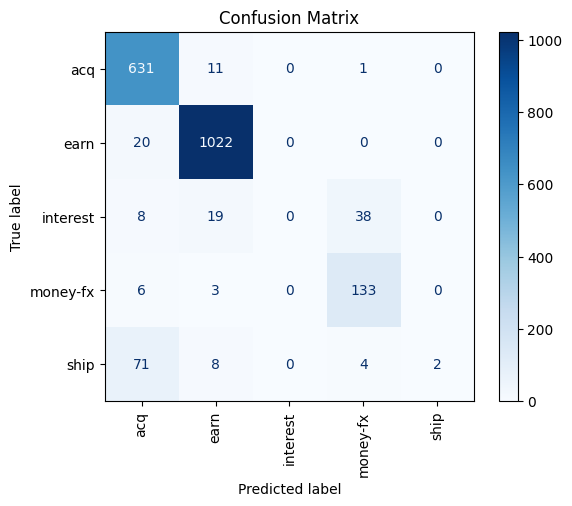

In [37]:
# Create a pipeline that combines the TfidfVectorizer and the MultinomialNB classifier
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
model.fit(X_train, y_train)

# Predict the topics for the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation="vertical")  # Customize display
plt.title("Confusion Matrix")
plt.show()

### Logistic Regression

Accuracy: 0.9645928174001012
Classification Report:
               precision    recall  f1-score   support

         acq       0.97      0.99      0.98       643
        earn       0.99      0.98      0.99      1042
    interest       0.76      0.65      0.70        65
    money-fx       0.82      0.92      0.87       142
        ship       0.99      0.96      0.98        85

    accuracy                           0.96      1977
   macro avg       0.91      0.90      0.90      1977
weighted avg       0.97      0.96      0.96      1977



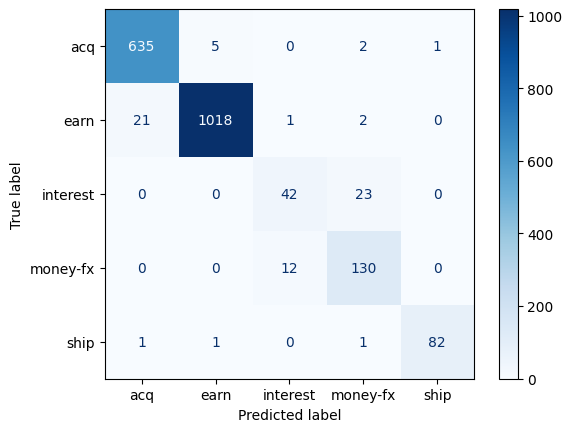

In [35]:
# Create a pipeline that combines the TfidfVectorizer and the LogisticRegression classifier
logistic_model = make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression(class_weight='balanced')  # Handle imbalanced data
)

# Train the model
logistic_model.fit(X_train, y_train)

# Predict the topics for the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)
disp.plot(cmap="Blues")

### Random Forest

Accuracy: 0.9524532119372787
Classification Report:
               precision    recall  f1-score   support

         acq       0.94      0.98      0.96       643
        earn       0.99      0.98      0.99      1042
    interest       0.96      0.35      0.52        65
    money-fx       0.77      0.94      0.85       142
        ship       1.00      0.82      0.90        85

    accuracy                           0.95      1977
   macro avg       0.93      0.82      0.84      1977
weighted avg       0.96      0.95      0.95      1977



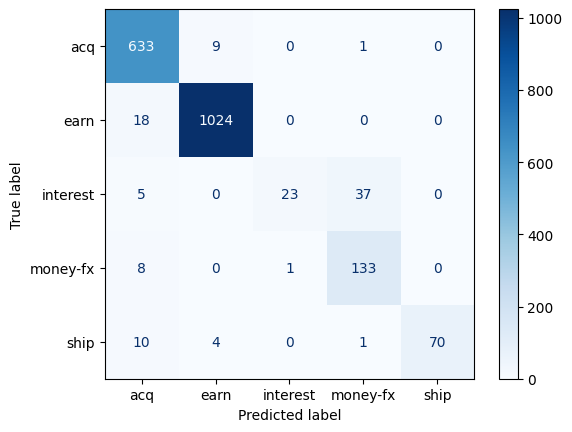

In [39]:
# Create a pipeline that combines the TfidfVectorizer and the RandomForestClassifier
random_forest_model = make_pipeline(
    TfidfVectorizer(), 
    RandomForestClassifier(class_weight="balanced")  # Handle imbalanced data
)

# Train the model
random_forest_model.fit(X_train, y_train)

# Predict the topics for the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf, labels=random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=random_forest_model.classes_)
disp.plot(cmap="Blues")

### SVC (Support Vector Classifier)

Accuracy: 0.9590288315629742
Classification Report:
               precision    recall  f1-score   support

         acq       0.95      0.99      0.97       643
        earn       0.99      0.98      0.99      1042
    interest       0.91      0.45      0.60        65
    money-fx       0.78      0.96      0.86       142
        ship       1.00      0.85      0.92        85

    accuracy                           0.96      1977
   macro avg       0.93      0.85      0.87      1977
weighted avg       0.96      0.96      0.96      1977



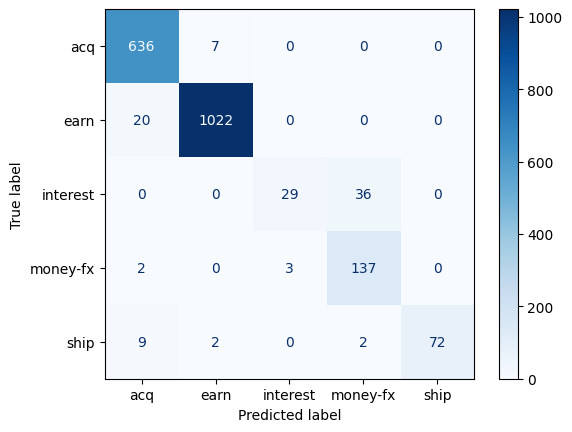

In [41]:
# Create a pipeline that combines the TfidfVectorizer and the SVC classifier
svc_model = make_pipeline(
    TfidfVectorizer(),
    SVC(class_weight="balanced")  # Handle imbalanced data
)

# Train the model
svc_model.fit(X_train, y_train)

# Predict the topics for the test set
y_pred_svc = svc_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svc, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svc_model.classes_)
disp.plot(cmap="Blues")

### XGBoost

c:\Users\moham\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9580171977744056
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       643
           1       0.98      0.99      0.98      1042
           2       0.73      0.54      0.62        65
           3       0.81      0.91      0.86       142
           4       0.99      0.94      0.96        85

    accuracy                           0.96      1977
   macro avg       0.90      0.87      0.88      1977
weighted avg       0.96      0.96      0.96      1977



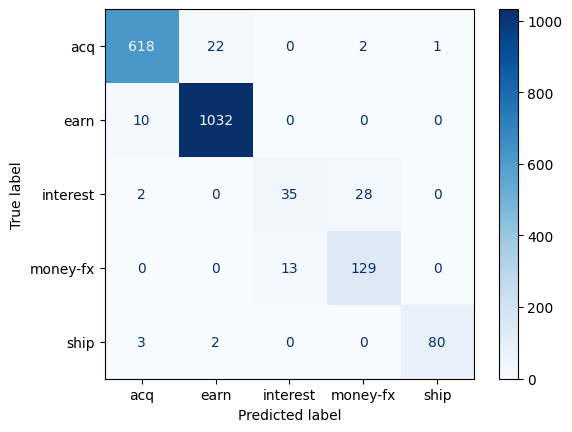

In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create a pipeline that combines the TfidfVectorizer and the XGBoost classifier
xgb_model = make_pipeline(
    TfidfVectorizer(),
    XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        scale_pos_weight=None  # You can adjust this depending on the data
    )
)

# Train the model
xgb_model.fit(X_train, y_train_encoded)

# Predict the topics for the test set
y_pred_xgb_encoded = xgb_model.predict(X_test)

# Convert predicted labels back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb_encoded))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb_encoded))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb_encoded, labels=range(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")

### MLP (Multi Layer Perceptron)

Accuracy: 0.9656044511886697
Classification Report:
               precision    recall  f1-score   support

         acq       0.98      0.98      0.98       643
        earn       0.99      0.99      0.99      1042
    interest       0.92      0.52      0.67        65
    money-fx       0.79      0.96      0.87       142
        ship       1.00      0.91      0.95        85

    accuracy                           0.97      1977
   macro avg       0.93      0.87      0.89      1977
weighted avg       0.97      0.97      0.96      1977



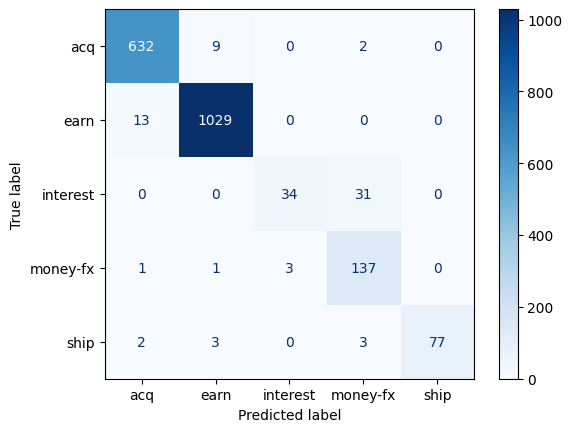

In [48]:
# Create a pipeline that combines the TfidfVectorizer and the MLPClassifier
mlp_model = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))

# Train the model
mlp_model.fit(X_train, y_train)

# Predict the topics for the test set
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp_model.classes_)
disp.plot(cmap="Blues")

### LLMs approach (Gemini)

In [82]:
def classify_topic(article_body):
    response = generative_multimodal_model.generate_content(
        [
            f"Knowing that the topic : Money/Foreign Exchange is (MONEY-FX), Shipping is (SHIP), Interest Rates is (INTEREST), Mergers/Acquisitions is (ACQ), Earnings and Earnings Forecasts is (EARN). Classify the following article into one of these topics: [money-fx, interest, ship, acq, earn].\nArticle: {article_body}\nTopic:"
        ]
    )
    # Nettoyer la réponse pour s'assurer que seul le topic est retourné
    return response.text.strip().split()[0]  # Prendre uniquement le premier mot

# Processus de classification des articles
def classify_articles_gemini(df):
    results = []
    for idx, row in df.iterrows():
        try:
            # Prédire le topic directement à partir du BODY
            predicted_topic = classify_topic(row["BODY"])
            results.append(
                {
                    "Article ID": idx,
                    "True Topic": row["TOPICS"],
                    "Predicted Topic": predicted_topic,
                }
            )
        except Exception as e:
            print(f"Error processing Article ID {idx}: {e}")
    return pd.DataFrame(results)

# Évaluation des performances
def evaluate_performance(results_df):
    y_true = results_df["True Topic"]
    y_pred = results_df["Predicted Topic"]
    
    # Calculer et afficher l'accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Afficher les métriques de classification
    print("Classification Report:")
    print(classification_report(y_true, y_pred))


In [83]:
# Charger les données test depuis le lewissplit
test_df = df_cleaned[df_cleaned["LEWISSPLIT"] == "TEST"]

# Classification des articles
classification_results = classify_articles_gemini(test_df)

In [84]:
len(classification_results)

1977

In [87]:
classification_results["True Topic"] = classification_results["True Topic"].str.upper()
classification_results["Predicted Topic"] = classification_results["Predicted Topic"].str.upper()

In [92]:
classification_results["Predicted Topic"].value_counts()

Predicted Topic
EARN        1029
ACQ          654
MONEY-FX     110
INTEREST     100
SHIP          79
NONE           4
THE            1
Name: count, dtype: int64

In [93]:
# Liste des topics valides
valid_topics = ["MONEY-FX", "INTEREST", "SHIP", "ACQ", "EARN"]

# Filtrer les prédictions non pertinentes
classification_results["Predicted Topic"] = classification_results["Predicted Topic"].apply(
    lambda x: x if x in valid_topics else "UNKNOWN"
)

# Supprimer les lignes avec des prédictions "UNKNOWN" pour éviter les biais dans l'évaluation
filtered_results = classification_results[classification_results["Predicted Topic"] != "UNKNOWN"]

# Vérifier la distribution des topics après filtrage
print(filtered_results["Predicted Topic"].value_counts())

Predicted Topic
EARN        1029
ACQ          654
MONEY-FX     110
INTEREST     100
SHIP          79
Name: count, dtype: int64


In [94]:
# Évaluer les performances uniquement sur les données valides
evaluate_performance(filtered_results)

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         ACQ       0.97      1.00      0.98       640
        EARN       1.00      0.98      0.99      1045
    INTEREST       0.60      0.92      0.73        65
    MONEY-FX       0.93      0.72      0.81       142
        SHIP       1.00      0.99      0.99        80

    accuracy                           0.97      1972
   macro avg       0.90      0.92      0.90      1972
weighted avg       0.97      0.97      0.97      1972



## Bonus 
Prédire les topics des articles ayant un body non vide et un topic non renseigné.

In [ ]:
# Directory containing the .sgm files
directory = 'reuters21578'

# Process all .sgm files and create a DataFrame
df = process_all_sgm_files(directory)

# Supprimer les articles sans body
df = df.dropna(subset=['BODY'])

# Étape 1 : Filtrer les articles sans topics
missing_topics_df = df[df["TOPICS"].apply(lambda x: x == [])]

In [100]:
missing_topics_df.sample(3)

,TITLE,LEWISSPLIT,PLACES,DATE,DATELINE,BODY,TOPICS
17184,U.S. CREDIT MARKET OUTLOOK - BUDGET DEFICIT,TRAIN,[],20-MAR-1987 08:09:53.54,"NEW YORK, March 20 -",Economists' forecasts vary widely for\nthe Feb...,[]
19492,AMR <AMR> AMERICAN AIR OFFERS TO SHIFT FLIGHTS,TEST,[usa],9-APR-1987 15:51:46.57,"DALLAS, April 9 -",AMR Corp's American Airlines said it is\nprepa...,[]
5804,SOUTHWEST AIR <LUV> UNIT ADDS HOUSTON NONSTOPS,TRAIN,[usa],11-MAR-1987 13:16:32.67,"HOUSTON, March 11 -",Southwest Airlines Co's TranStar\nAirlines Cor...,[]


In [118]:
def predict_topic_with_gemini(article_body):
    try:
        # Générer le topic avec Gemini
        response = generative_multimodal_model.generate_content(
            [
                f"Knowing that the topic : Money/Foreign Exchange is (MONEY-FX), Shipping is (SHIP), Interest Rates is (INTEREST), Mergers/Acquisitions is (ACQ), Earnings and Earnings Forecasts is (EARN). Classify the following article into one of these topics: [money-fx, interest, ship, acq, earn] (Respond only by the name of the topic).\n\nArticle: {article_body}\n\nTopic:"
            ]
        )
        predicted_topic = response.text.strip().upper()
        return predicted_topic 
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return "UNKNOWN"

In [119]:
# Étape 2 : Sélectionner 5 exemples aléatoires
examples_to_predict = missing_topics_df.sample(5)

# Étape 4 : Prédire les topics pour les exemples
examples_to_predict["Predicted Topic"] = examples_to_predict["BODY"].apply(predict_topic_with_gemini)

In [124]:
# Étape 5 : Afficher les résultats
print(examples_to_predict["BODY"].iloc[0])

print(examples_to_predict["Predicted Topic"].iloc[0])

Bank of Montreal <BMO.M> Chairman
William Mulholland said he was reasonably optimistic that debt
negotiations between Brazil and its commercial bank creditors
can be accomplished satisfactorily in the long run.
    "It's going to be a bit rocky short term ... a couple of
months ... but I am reasonably optimistic longer term," he told
a press briefing here.
    Earlier, Mulholland announced that Bank of Montreal has
formally applied to swap up to 100 mln dlrs of its roughly one
billion dlr cross border exposure to Brazil into local equity
investments under a novel conversion scheme.
    Tensions have been running high between Brazil and its bank
creditors since President Jose Sarney imposed a unilateral
suspension of interest payments on some 68 billion dlrs of
commercial bank debt on February 20, bankers said.
    Only yesterday, three leading U.S. banks voluntarily put
their Brazilian loans on non-accrual status and took a hefty
cut in net income for the first quarter ended March 31.
